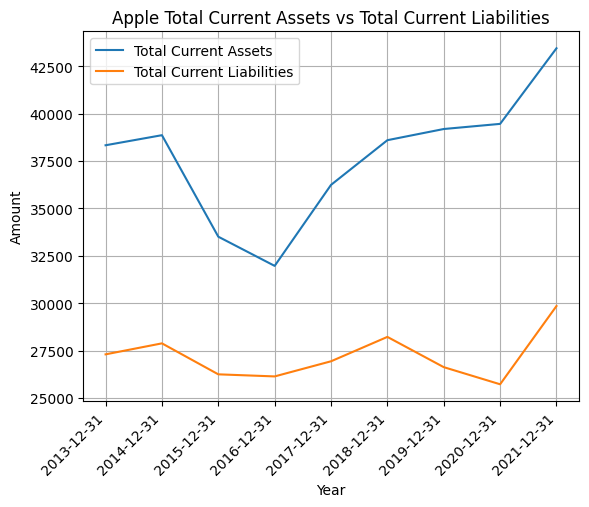

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file into a pandas dataframe
df = pd.read_csv('../apple_income_statement.csv', index_col=0)

# Select only the "Total Current Assets" and "Total Current Liabilities" data
current_assets = df.loc['Total Current Assets'][1:]
current_liabilities = df.loc['Total Current Liabilities'][1:]

# Plot the data
plt.plot(current_assets.index, current_assets.values, label='Total Current Assets')
plt.plot(current_liabilities.index, current_liabilities.values, label='Total Current Liabilities')

# Add title and labels to the plot
plt.title('Apple Total Current Assets vs Total Current Liabilities')
plt.xlabel('Year')
plt.ylabel('Amount')

plt.xticks(rotation=45, ha='right')  # rotate x-axis labels by 45 degrees and align right

# Add legend and a grid to the plot
plt.legend()
plt.grid()

# Show the plot
plt.show()

Data from: https://www.kaggle.com/datasets/thedevastator/apple-s-historical-financials

In [22]:
len(current_assets)

9

Let's try training a linear regression model to predict total current assets and total current liabilities. It will probably not be that accurate, as the amount of data we are working with is very little, but let's try anyways. First, let's try only working with assets. We need train and test splits. We only have 9 values to work with, so let's try to predict two of them - one sampled from the middle and on from the end.

In [2]:
import numpy as np

In [24]:
test_indices = np.array([4, 8])
train_indices = np.array([i for i in np.arange(len(current_assets)) if i not in test_indices])
test_indices, train_indices

(array([4, 8]), array([0, 1, 2, 3, 5, 6, 7]))

In [25]:
train = current_assets.loc[current_assets.index[train_indices]]
test = current_assets.loc[current_assets.index[test_indices]]
train, test

(2013-12-31    38335
 2014-12-31    38867
 2015-12-31    33508
 2016-12-31    31967
 2018-12-31    38603
 2019-12-31    39193
 2020-12-31    39464
 Name: Total Current Assets, dtype: int64,
 2017-12-31    36244
 2021-12-31    43455
 Name: Total Current Assets, dtype: int64)

In [26]:
train.index

Index(['2013-12-31', '2014-12-31', '2015-12-31', '2016-12-31', '2018-12-31',
       '2019-12-31', '2020-12-31'],
      dtype='object')

Let's visualise which points are training data and which are testing:

In [3]:
def visualise_train_test_split(train, test, title, x_axis, y_axis, train_indices= None, test_indices = None, set_xticks=True):
    fig, ax = plt.subplots(1, 1)
    plt.close()
    ax.set_title(title)
    ax.set_xlabel(x_axis)
    ax.set_ylabel(y_axis)
    
    ax.scatter(train_indices if train_indices is not None else train.index, train.values, label='Train')
    ax.scatter(test_indices if test_indices is not None else test.index, test.values, label='Test')

    if set_xticks and train_indices is not None and test_indices is not None:
        ax.set_xticks(np.append(train_indices, test_indices), np.append(train.index, test.index), rotation=45)
    elif set_xticks:
        ax.set_xticks(rotation=45)

    ax.legend()

    return fig, ax

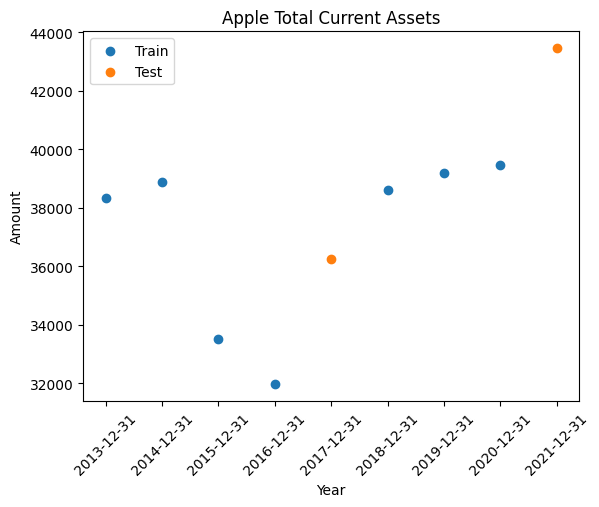

In [28]:
fig, ax = visualise_train_test_split(train, test, 'Apple Total Current Assets', 'Year', 'Amount', train_indices, test_indices)
fig

Now let's train a linear regression model and visualise it:

In [29]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(train_indices.reshape((-1, 1)), train.values.reshape((-1, 1)))

predictions = lr.predict(test_indices.reshape((-1, 1))).flatten()
list(zip(test_indices, predictions))

[(4, 37339.232876712325), (8, 38776.86301369863)]

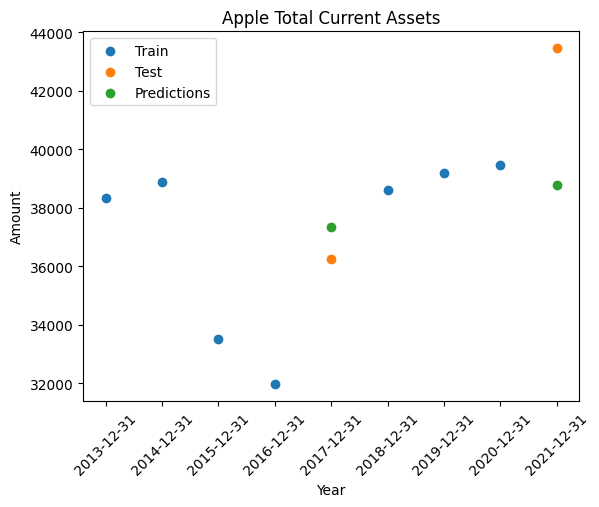

In [30]:
ax.scatter(test_indices, predictions, label='Predictions')
ax.legend()

fig

While it's relatively close for the prediction for 2017, the results are suboptimal. Let's look at the curve for entire time interval

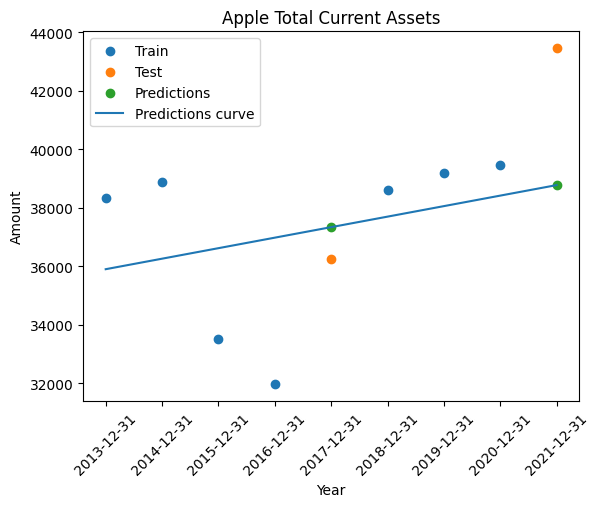

In [31]:
ax.plot(np.arange(len(current_assets)), lr.predict(np.arange(len(current_assets)).reshape((-1, 1))).flatten(), label='Predictions curve')
ax.legend()

fig

The curve, while predicting the general trend, is definitely too linear and inaccurate. ChatGPT suggests to use a different classifier - polynomial regression. While it's still my suspicion that there's too litle data, let's try it out just in case.

In [32]:

from sklearn.preprocessing import PolynomialFeatures

polynomial_features = PolynomialFeatures(degree=2)
X_poly = polynomial_features.fit_transform(train_indices.reshape((-1, 1)))

# create and fit the polynomial regression model
poly_reg = LinearRegression()
poly_reg.fit(X_poly, train.values.reshape((-1, 1)))

test_features = polynomial_features.transform(test_indices.reshape(-1, 1))

polynomial_predictions = poly_reg.predict(test_features).flatten()

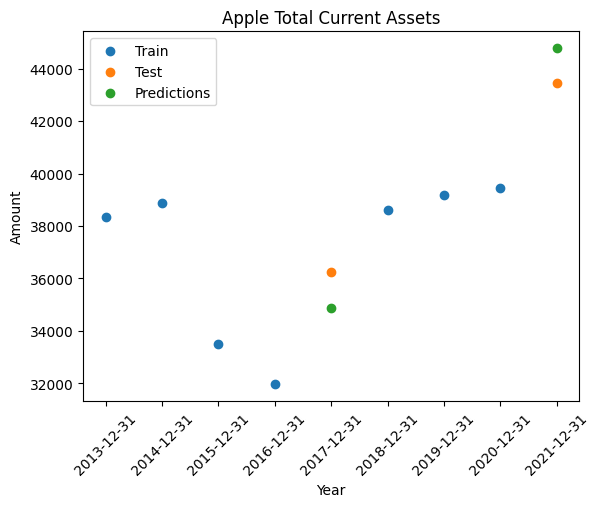

In [33]:
poly_fig, poly_ax = visualise_train_test_split(train, test, 'Apple Total Current Assets', 'Year', 'Amount', train_indices, test_indices)

poly_ax.scatter(test_indices, polynomial_predictions, label='Predictions')
poly_ax.legend()

poly_fig

Here we definitely get closer to the actual assets. Let's compare the curves:

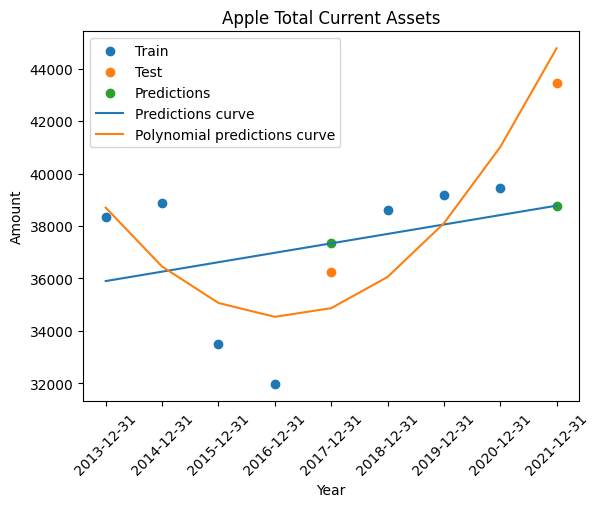

In [34]:
test_features = polynomial_features.transform(np.arange(len(current_assets)).reshape(-1, 1))

ax.plot(np.arange(len(current_assets)), poly_reg.predict(test_features).flatten(), label='Polynomial predictions curve')
ax.legend()

fig

Here, the curve reflects the actual vaues slighyly better, however it's still very innacurate, and essiantially because we have so little amount of data here, we're essenialy trying to fit the curve to it instead of getting any useful regression-based predictor. This curve would be absolutely useless to predict, for example, the assets of 2022.

I have downloaded a weather temperature dataset during WW2 from kaggle (https://www.kaggle.com/datasets/smid80/weatherww2?resource=download). It has a lot more datapoints. Let's make train and test splits using sklearn and visualise it.

In [4]:
weather_df = pd.read_csv('../Summary of Weather.csv')
weather_df.describe()

/tmp/ipykernel_1551/2796150377.py:1: DtypeWarning: Columns (7,8,18,25) have mixed types. Specify dtype option on import or set low_memory=False.
  weather_df = pd.read_csv('../Summary of Weather.csv')


,STA,WindGustSpd,MaxTemp,MinTemp,MeanTemp,YR,MO,DA,DR,SPD,...,FT,FB,FTI,ITH,PGT,SD3,RHX,RHN,RVG,WTE
count,119040.000000,532.000000,119040.000000,119040.000000,119040.000000,119040.000000,119040.000000,119040.000000,533.000000,532.000000,...,0.0,0.0,0.0,0.0,525.000000,0.0,0.0,0.0,0.0,0.0
mean,29659.435795,37.774534,27.045111,17.789511,22.411631,43.805284,6.726016,15.797530,26.998124,20.396617,...,NaN,NaN,NaN,NaN,12.085333,NaN,NaN,NaN,NaN,NaN
std,20953.209402,10.297808,8.717817,8.334572,8.297982,1.136718,3.425561,8.794541,15.221732,5.560371,...,NaN,NaN,NaN,NaN,5.731328,NaN,NaN,NaN,NaN,NaN
min,10001.000000,18.520000,-33.333333,-38.333333,-35.555556,40.000000,1.000000,1.000000,2.000000,10.000000,...,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
25%,11801.000000,29.632000,25.555556,15.000000,20.555556,43.000000,4.000000,8.000000,11.000000,16.000000,...,NaN,NaN,NaN,NaN,8.500000,NaN,NaN,NaN,NaN,NaN
50%,22508.000000,37.040000,29.444444,21.111111,25.555556,44.000000,7.000000,16.000000,32.000000,20.000000,...,NaN,NaN,NaN,NaN,11.600000,NaN,NaN,NaN,NaN,NaN
75%,33501.000000,43.059000,31.666667,23.333333,27.222222,45.000000,10.000000,23.000000,34.000000,23.250000,...,NaN,NaN,NaN,NaN,15.000000,NaN,NaN,NaN,NaN,NaN
max,82506.000000,75.932000,50.000000,34.444444,40.000000,45.000000,12.000000,31.000000,78.000000,41.000000,...,NaN,NaN,NaN,NaN,23.900000,NaN,NaN,NaN,NaN,NaN


In [5]:
from sklearn.model_selection import train_test_split

x = weather_df['MinTemp']
y = weather_df['MaxTemp']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=1)

In [6]:
x_train[:5], y_train[:5]

(19688     25.000000
 86927     17.222222
 114506     3.333333
 86725      1.666667
 116837    20.000000
 Name: MinTemp, dtype: float64,
 19688     30.000000
 86927     36.111111
 114506    15.000000
 86725     15.555556
 116837    34.444444
 Name: MaxTemp, dtype: float64)

Because the dataset is so big, let's visualise a fraction of it.

In [7]:
random_test_indices = np.random.randint(0, len(x_test), size=int(len(x_test)/100))
random_train_indices = np.random.randint(0, len(x_train), size=int(len(x_train)/100))

y_train_visualise = np.take(y_train, random_train_indices)
x_train_visualise = np.take(x_train, random_train_indices)
y_test_visualise = np.take(y_test, random_test_indices)
x_test_visualise = np.take(x_test, random_test_indices)

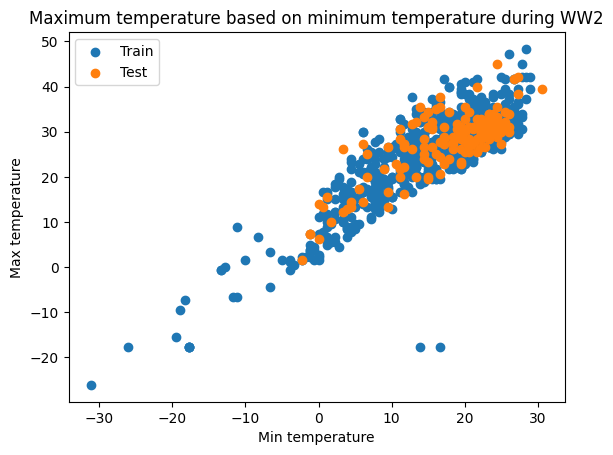

In [13]:
fig, ax = visualise_train_test_split(y_train_visualise, y_test_visualise, 'Maximum temperature based on minimum temperature during WW2', 'Min temperature', 'Max temperature', x_train_visualise, x_test_visualise, set_xticks=False)
fig

Looking at the data, here Linear regression should work a lot better. Let's try it out. Let's train on the entire training set, but predict only on visualisation test subset, as in this case we are not measuring accuracy and only care about the points we can visually look at.

In [14]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(x_train.to_numpy().reshape((-1, 1)), y_train.to_numpy().reshape((-1, 1)))

predictions = lr.predict(x_test_visualise.to_numpy().reshape((-1, 1))).flatten()

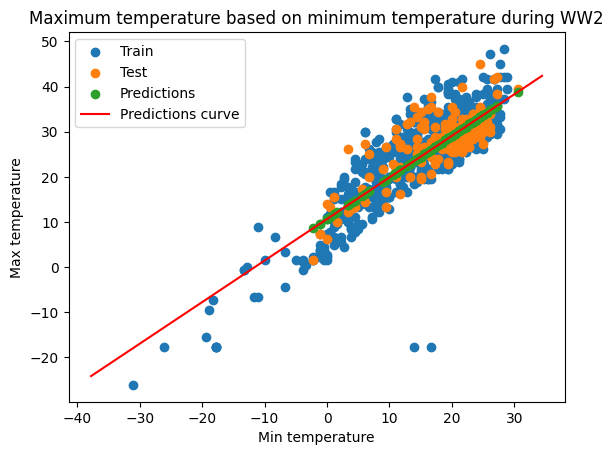

In [15]:
ax.scatter(x_test_visualise, predictions, label='Predictions')

curve_x = np.arange(np.min(x_train), np.max(x_train), 0.1)
curve_y = lr.predict(curve_x.reshape((-1, 1))).flatten()

ax.plot(curve_x, curve_y, label='Predictions curve', c='r')
ax.legend()

fig

Here the linear regression curve fits a lot better. There's little variation, but in general it looks about right.